In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.datasets import load_files
from keras.utils import to_categorical
from __future__ import absolute_import
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from glob import *
from tqdm import tqdm
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.models import clone_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.applications.xception import Xception, preprocess_input
from keras.callbacks import History
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = tf.keras.utils.to_categorical(np.array(data['target']))
    return dog_files, dog_targets
train_files, train_targets = load_dataset('/content/drive/My Drive/dogImages/train')
valid_files, valid_targets = load_dataset('/content/drive/My Drive/dogImages/valid')
test_files, test_targets = load_dataset('/content/drive/My Drive/dogImages/test')
dog_names = [item[20:-1] for item in sorted(glob("/content/drive/My Drive/dogImages/train/*/"))]

In [5]:
def path_to_tensor(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)
def paths_to_tensor(img_paths, target_size = (224, 224)):
    list_of_tensors = [path_to_tensor(img_path, target_size) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 109.23it/s]


In [5]:
ResNet50_model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 1s 0us/step


In [8]:
def ResNet50_predicts(img_path):
  img = preprocess_input(path_to_tensor(img_path))
  return np.argmax(ResNet50_model.predict(img))

In [9]:
def dog_detector(img_path):
  prediction = ResNet50_predicts(img_path)
  return((prediction <= 268)&(prediction >= 151))
dog_detector('/content/drive/My Drive/dogImages/train/034.Boxer/Boxer_02360.jpg')

True

In [23]:
bottleneck_features =np.load('/content/drive/My Drive/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [24]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))
Resnet50_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [28]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/Resnet50weight.hdf5', verbose=1, save_best_only=True)
Resnet50_model.fit(train_Resnet50, train_targets, validation_data=(valid_Resnet50, valid_targets),epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)
Resnet50_model.load_weights('/content/drive/My Drive/Resnet50weight.hdf5')
resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]
test_accuracy = 100*np.sum(np.array(resnet50_predictions)==np.argmax(test_targets, axis=1))/len(resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Epoch 1/20
332/334 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9982
Epoch 00001: val_loss improved from inf to 0.97067, saving model to /content/drive/My Drive/Resnet50weight.hdf5
334/334 [==============================] - 1s 4ms/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.9707 - val_accuracy: 0.8311
Epoch 2/20
325/334 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9985
Epoch 00002: val_loss improved from 0.97067 to 0.90704, saving model to /content/drive/My Drive/Resnet50weight.hdf5
334/334 [==============================] - 1s 4ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.9070 - val_accuracy: 0.8251
Epoch 3/20
331/334 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9989
Epoch 00003: val_loss did not improve from 0.90704
334/334 [==============================] - 1s 4ms/step - loss: 0.0072 - accuracy: 0.9988 - val_loss: 0.9225 - val_accuracy: 0.8323
Epoch 4/20
325/334 [====================

In [26]:
Resnet50_model.save('/content/drive/My Drive/Resnet50model.h5')

In [12]:
inception_bottleneck_features =np.load('/content/drive/My Drive/DogInceptionData.npz')
train_Inception = inception_bottleneck_features['train']
valid_Inception = inception_bottleneck_features['valid']
test_Inception = inception_bottleneck_features['test']

In [13]:
Inception_model = Sequential()
Inception_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Inception_model.add(Dense(133, activation='softmax'))
Inception_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [19]:
Inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/InceptionWeight.hdf5', verbose=1, save_best_only=True)
Inception_model.fit(train_Inception, train_targets, validation_data=(valid_Inception, valid_targets),epochs=30, batch_size=20, callbacks=[checkpointer], verbose=1)
Inception_model.load_weights('/content/drive/My Drive/InceptionWeight.hdf5')
Inception_predictions = [np.argmax(Inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Inception]
test_accuracy = 100*np.sum(np.array(Inception_predictions)==np.argmax(test_targets, axis=1))/len(Inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Epoch 1/30
334/334 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9981WARNING:tensorflow:Model was constructed with shape (None, 1, 1, 2048) for input Tensor("global_average_pooling2d_1_input:0", shape=(None, 1, 1, 2048), dtype=float32), but it was called on an input with incompatible shape (None, 5, 5, 2048).

Epoch 00001: val_loss improved from inf to 1.26986, saving model to /content/drive/My Drive/InceptionWeight.hdf5
334/334 [==============================] - 3s 10ms/step - loss: 0.0082 - accuracy: 0.9981 - val_loss: 1.2699 - val_accuracy: 0.8467
Epoch 2/30
330/334 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9983
Epoch 00002: val_loss improved from 1.26986 to 1.26494, saving model to /content/drive/My Drive/InceptionWeight.hdf5
334/334 [==============================] - 2s 7ms/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 1.2649 - val_accuracy: 0.8491
Epoch 3/30
327/334 [============================>.] - ETA: 0s - loss: 0.0

Epoch 1/30
325/334 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9986
Epoch 00001: val_loss did not improve from 0.60342
334/334 [==============================] - 2s 5ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 1.1544 - val_accuracy: 0.8275
Epoch 2/30
331/334 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9988
Epoch 00002: val_loss did not improve from 0.60342
334/334 [==============================] - 2s 5ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 1.1732 - val_accuracy: 0.8251
Epoch 3/30
326/334 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.9986
Epoch 00003: val_loss did not improve from 0.60342
334/334 [==============================] - 2s 5ms/step - loss: 0.0038 - accuracy: 0.9987 - val_loss: 1.1718 - val_accuracy: 0.8359
Epoch 4/30
329/334 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9985
Epoch 00004: val_loss did not improve from 0.60342
334/334 [==========

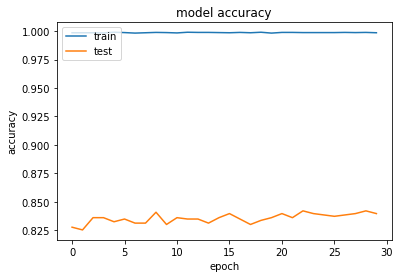

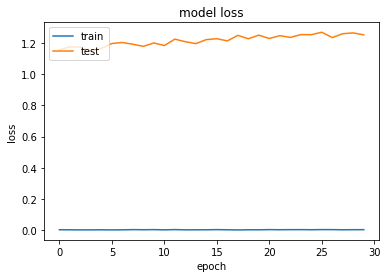

In [17]:
history = Resnet50_model.fit(train_Resnet50, train_targets, validation_data=(valid_Resnet50, valid_targets),epochs=30, batch_size=20, callbacks=[checkpointer], verbose=1)
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
Inception_model.save('/content/drive/My Drive/Inceptionmodel.h5')

Epoch 1/20
334/334 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.9928
Epoch 00001: val_loss did not improve from 0.60342
334/334 [==============================] - 3s 8ms/step - loss: 0.0229 - accuracy: 0.9928 - val_loss: 1.0311 - val_accuracy: 0.8467
Epoch 2/20
329/334 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9930
Epoch 00002: val_loss did not improve from 0.60342
334/334 [==============================] - 2s 7ms/step - loss: 0.0203 - accuracy: 0.9928 - val_loss: 1.0621 - val_accuracy: 0.8599
Epoch 3/20
331/334 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9940
Epoch 00003: val_loss did not improve from 0.60342
334/334 [==============================] - 2s 7ms/step - loss: 0.0177 - accuracy: 0.9939 - val_loss: 1.0809 - val_accuracy: 0.8515
Epoch 4/20
326/334 [============================>.] - ETA: 0s - loss: 0.0169 - accuracy: 0.9956
Epoch 00004: val_loss did not improve from 0.60342
334/334 [==========

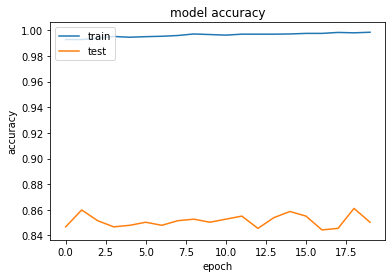

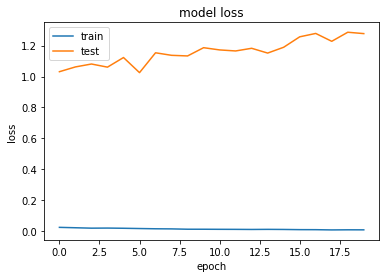

In [18]:
history = Inception_model.fit(train_Inception, train_targets, validation_data=(valid_Inception, valid_targets),epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [6]:
Resnet50_Model=load_model('/content/drive/My Drive/Resnet50model.h5')

In [11]:
Resnet50_Model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/weight.hdf5', verbose=1, save_best_only=True)
Resnet50_Model.fit(train_Resnet50, train_targets, validation_data=(valid_Resnet50, valid_targets),epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)
Resnet50_Model.load_weights('/content/drive/My Drive/weight.hdf5')
resnet50_predictions = [np.argmax(Resnet50_Model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]
test_accuracy = 100*np.sum(np.array(resnet50_predictions)==np.argmax(test_targets, axis=1))/len(resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Epoch 1/20
326/334 [============================>.] - ETA: 0s - loss: 0.0973 - accuracy: 0.9706
Epoch 00001: val_loss improved from inf to 0.74941, saving model to /content/drive/My Drive/weight.hdf5
334/334 [==============================] - 2s 6ms/step - loss: 0.0984 - accuracy: 0.9699 - val_loss: 0.7494 - val_accuracy: 0.8000
Epoch 2/20
329/334 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9787
Epoch 00002: val_loss improved from 0.74941 to 0.73390, saving model to /content/drive/My Drive/weight.hdf5
334/334 [==============================] - 1s 4ms/step - loss: 0.0688 - accuracy: 0.9787 - val_loss: 0.7339 - val_accuracy: 0.8120
Epoch 3/20
326/334 [============================>.] - ETA: 0s - loss: 0.0493 - accuracy: 0.9845
Epoch 00003: val_loss did not improve from 0.73390
334/334 [==============================] - 1s 4ms/step - loss: 0.0491 - accuracy: 0.9843 - val_loss: 0.7600 - val_accuracy: 0.8108
Epoch 4/20
324/334 [============================>.] - ET

In [12]:
# train_datagen = ImageDataGenerator(rotation_range=5,horizontal_flip=True)

In [19]:
history = Resnet50_Model.fit(train_datagen.flow(train_Resnet50, train_targets,batch_size=20), validation_data=(valid_Resnet50, valid_targets),epochs=30, callbacks=[checkpointer], verbose=1)
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (6680, 1, 1, 2048) (2048 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


ValueError: ignored

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,brightness_range=[0.9,1.1],width_shift_range=0.05,height_shift_range=0.05,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('dogImages/train',target_size=(224, 224),batch_size=batch_size,class_mode='categorical')
validation_generator = test_datagen.flow_from_directory('dogImages/valid',target_size=(224, 224),batch_size=batch_size,class_mode='categorical')
history = Resnet50Model.fit(train_Resnet50, train_targets, validation_data=(valid_Resnet50, valid_targets),epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
328/334 [============================>.] - ETA: 0s - loss: 0.0950 - accuracy: 0.9712
Epoch 00001: val_loss improved from inf to 0.72972, saving model to /content/drive/My Drive/weight.hdf5
334/334 [==============================] - 2s 7ms/step - loss: 0.0946 - accuracy: 0.9713 - val_loss: 0.7297 - val_accuracy: 0.8192
Epoch 2/20
329/334 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9798
Epoch 00002: val_loss improved from 0.72972 to 0.66180, saving model to /content/drive/My Drive/weight.hdf5
334/334 [==============================] - 2s 5ms/step - loss: 0.0645 - accuracy: 0.9801 - val_loss: 0.6618 - val_accuracy: 0.8240
Epoch 3/20
324/334 [============================>.] - ETA: 0s - loss: 0.0493 - accuracy: 0.9867
Epoch 00003: val_loss did not improve from 0.66180
334/334 [==============================] - 2s 5ms/step - loss: 0.0489 - accuracy: 0.9868 - val_loss: 0.7502 - val_accuracy: 0.8012
Epoch 4/20
327/334 [============================>.] - ET

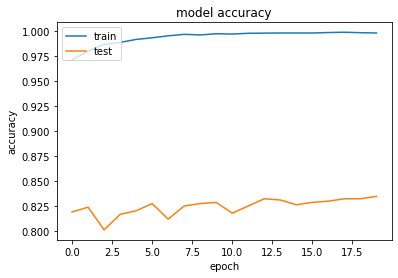

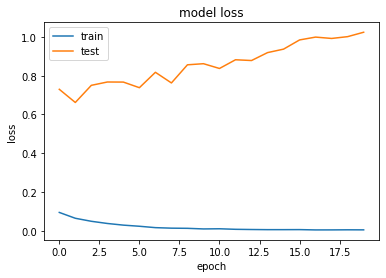

In [26]:
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/weight.hdf5', verbose=1, save_best_only=True)
history = Resnet50Model.fit(train_Resnet50, train_targets, validation_data=(valid_Resnet50, valid_targets),epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
#scratch
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3,padding='same', activation='relu')
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

In [10]:
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/scratchWeight.hdf5', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Epoch 1/50
334/334 [==============================] - ETA: 0s - loss: 4.8856 - accuracy: 0.0108
Epoch 00001: val_loss improved from inf to 4.84295, saving model to /content/drive/My Drive/scratchWeight.hdf5
334/334 [==============================] - 404s 1s/step - loss: 4.8856 - accuracy: 0.0108 - val_loss: 4.8430 - val_accuracy: 0.0120
Epoch 2/50
334/334 [==============================] - ETA: 0s - loss: 4.7754 - accuracy: 0.0219
Epoch 00002: val_loss improved from 4.84295 to 4.74752, saving model to /content/drive/My Drive/scratchWeight.hdf5
334/334 [==============================] - 402s 1s/step - loss: 4.7754 - accuracy: 0.0219 - val_loss: 4.7475 - val_accuracy: 0.0240
Epoch 3/50
334/334 [==============================] - ETA: 0s - loss: 4.5686 - accuracy: 0.0347
Epoch 00003: val_loss improved from 4.74752 to 4.55398, saving model to /content/drive/My Drive/scratchWeight.hdf5
334/334 [==============================] - 399s 1s/step - loss: 4.5686 - accuracy: 0.0347 - val_loss: 4.554

In [7]:
xception_bottleneck_features =np.load('/content/drive/My Drive/DogXceptionData.npz')
train_Xception = xception_bottleneck_features['train']
valid_Xception = xception_bottleneck_features['valid']
test_Xception = xception_bottleneck_features['test']

In [12]:
Xception_Model = Sequential()
Xception_Model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_Model.add(Dense(133, activation='softmax'))
Xception_Model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [18]:
Xception_Model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/Xceptionweight.hdf5', verbose=1, save_best_only=True)
Xception_Model.fit(train_Xception, train_targets, validation_data=(valid_Xception, valid_targets),epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)
Xception_Model.load_weights('/content/drive/My Drive/Xceptionweight.hdf5')
dog_breed_predictions = [np.argmax(Xception_Model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_Xception]
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Epoch 1/20
331/334 [============================>.] - ETA: 0s - loss: 0.1918 - accuracy: 0.9384
Epoch 00001: val_loss improved from inf to 0.55302, saving model to /content/drive/My Drive/Xceptionweight.hdf5
334/334 [==============================] - 3s 9ms/step - loss: 0.1930 - accuracy: 0.9385 - val_loss: 0.5530 - val_accuracy: 0.8527
Epoch 2/20
334/334 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9501
Epoch 00002: val_loss did not improve from 0.55302
334/334 [==============================] - 3s 8ms/step - loss: 0.1677 - accuracy: 0.9501 - val_loss: 0.5606 - val_accuracy: 0.8671
Epoch 3/20
334/334 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9530
Epoch 00003: val_loss did not improve from 0.55302
334/334 [==============================] - 3s 8ms/step - loss: 0.1531 - accuracy: 0.9530 - val_loss: 0.5670 - val_accuracy: 0.8563
Epoch 4/20
332/334 [============================>.] - ETA: 0s - loss: 0.1386 - accuracy: 0.9583
Epoch 000

Epoch 1/20
330/334 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9923
Epoch 00001: val_loss did not improve from 0.55302
334/334 [==============================] - 3s 9ms/step - loss: 0.0290 - accuracy: 0.9924 - val_loss: 0.9322 - val_accuracy: 0.8431
Epoch 2/20
330/334 [============================>.] - ETA: 0s - loss: 0.0265 - accuracy: 0.9939
Epoch 00002: val_loss did not improve from 0.55302
334/334 [==============================] - 3s 8ms/step - loss: 0.0262 - accuracy: 0.9940 - val_loss: 0.8938 - val_accuracy: 0.8515
Epoch 3/20
332/334 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9931
Epoch 00003: val_loss did not improve from 0.55302
334/334 [==============================] - 3s 8ms/step - loss: 0.0250 - accuracy: 0.9931 - val_loss: 0.9081 - val_accuracy: 0.8503
Epoch 4/20
331/334 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9927
Epoch 00004: val_loss did not improve from 0.55302
334/334 [==========

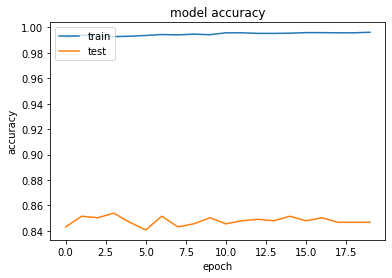

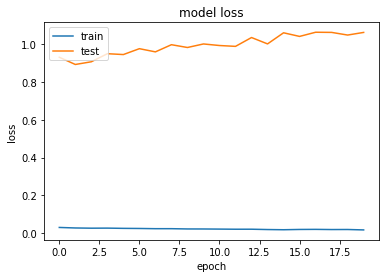

In [22]:
history = Xception_Model.fit(train_Xception, train_targets, validation_data=(valid_Xception, valid_targets),epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
$checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/scratchWeight.hdf5', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [2]:
batch_size = 16 
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
    )
test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rescale=1./255
    )
train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/dogImages/train',
    target_size = (299, 299),
    batch_size = batch_size,
    class_mode = 'categorical')
validation_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/dogImages/valid',
    target_size = (299, 299),
    batch_size = batch_size,
    class_mode = 'categorical')

FileNotFoundError: ignored

In [3]:
def load_xception_model_augmented(weights = None):
    xception_model_augmented = Sequential()
    Xception_cnn_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape = Xception_cnn_model.output_shape[1:]))
    model.add(Dense(512,activation = 'relu',kernel_regularizer = regularizers.l2(0.01))) #prevent overfitting
    model.add(Dropout(0.2))
    model.add(Dense(256,activation = 'relu',kernel_regularizer = regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(133, activation='softmax'))
    xception_model_augmented.add(Xception_cnn_model)
    xception_model_augmented.add(model)
    for layer in xception_model_augmented.layers[0].layers: # Freeze base model
        layer.trainable = False
    xception_model_augmented.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    if weights is not None:
      xception_model_augmented(weights)
    return xception_model_augmented

In [4]:
history = History()
checkpointer = ModelCheckpoint('/content/drive/My Drive/xception_augmented_weight_2.hdf5', verbose=1, save_best_only=True)

In [5]:
xception_model_augmented = load_xception_model_augmented()

83689472/83683744 [==============================] - 1s 0us/step


In [8]:
xception_model_augmented.load_weights('/content/drive/My Drive/xception_augmented_weight_2.hdf5')

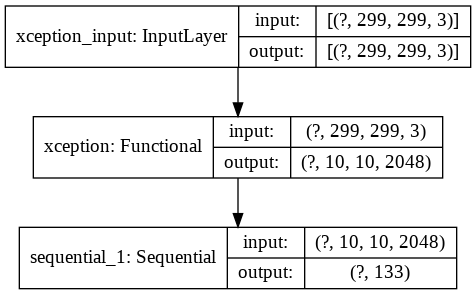

In [10]:
plot_model(xception_model_augmented, to_file='xception_plot.png', show_shapes=True, show_layer_names=True)

In [60]:
xception_model_augmented.fit(train_generator,steps_per_epoch = 6680 // batch_size,epochs = 10,validation_data = validation_generator,validation_steps = 835 // batch_size,callbacks = [checkpointer, history],verbose=2)

Epoch 1/10

Epoch 00001: val_loss improved from inf to 1.12985, saving model to /content/drive/My Drive/xception_augmented_weight_2.hdf5
417/417 - 2291s - loss: 1.3628 - accuracy: 0.7526 - val_loss: 1.1299 - val_accuracy: 0.8113
Epoch 2/10

Epoch 00002: val_loss did not improve from 1.12985
417/417 - 2295s - loss: 1.3245 - accuracy: 0.7658 - val_loss: 1.1466 - val_accuracy: 0.8317
Epoch 3/10

Epoch 00003: val_loss did not improve from 1.12985
417/417 - 2303s - loss: 1.3319 - accuracy: 0.7706 - val_loss: 1.1595 - val_accuracy: 0.8257
Epoch 4/10

Epoch 00004: val_loss did not improve from 1.12985
417/417 - 2296s - loss: 1.3275 - accuracy: 0.7722 - val_loss: 1.2373 - val_accuracy: 0.7921
Epoch 5/10

Epoch 00005: val_loss improved from 1.12985 to 1.10221, saving model to /content/drive/My Drive/xception_augmented_weight_2.hdf5
417/417 - 2317s - loss: 1.3327 - accuracy: 0.7652 - val_loss: 1.1022 - val_accuracy: 0.8353
Epoch 6/10

Epoch 00006: val_loss did not improve from 1.10221
417/417 - 

In [12]:
test_generator = test_datagen.flow_from_directory('/content/drive/My Drive/dogImages/test',target_size = (299, 299),batch_size = 1,class_mode = 'categorical',shuffle = False)

Found 836 images belonging to 133 classes.


In [14]:
print(classification_report(test_generator.labels, predict, target_names = dog_names))

                                                            precision    recall  f1-score   support

                     ive/dogImages/train/001.Affenpinscher       1.00      0.88      0.93         8
                      ive/dogImages/train/002.Afghan_hound       0.88      0.88      0.88         8
                  ive/dogImages/train/003.Airedale_terrier       1.00      1.00      1.00         6
                             ive/dogImages/train/004.Akita       0.62      1.00      0.76         8
                  ive/dogImages/train/005.Alaskan_malamute       0.91      1.00      0.95        10
               ive/dogImages/train/006.American_eskimo_dog       1.00      0.75      0.86         8
                 ive/dogImages/train/007.American_foxhound       1.00      0.71      0.83         7
    ive/dogImages/train/008.American_staffordshire_terrier       1.00      1.00      1.00         8
            ive/dogImages/train/009.American_water_spaniel       1.00      0.50      0.67         4

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
dog_names = [item[20:-1] for item in sorted(glob("/content/drive/My Drive/dogImages/train/*/"))]
def predict_xception(final_model, img_path):
    img = load_img(img_path, target_size = (299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    y = preprocess_input(x)/255
    predicted_vector = final_model.predict(y)
    results = sorted(enumerate(predicted_vector[0]), reverse=True, key=lambda x:x[1])
    classes_ind = [x[0] for x in results]
    ans = [dog_names[x] for x in classes_ind][0]
    return ans

In [16]:
predict_xception(xception_model_augmented, '/content/drive/My Drive/Great_Pyrenees_Mountain_Dog.jpg')

'ive/dogImages/train/079.Great_pyrenees'

In [17]:
predict_xception(xception_model_augmented, '/content/drive/My Drive/yorkshire-terrier.jpg')

'ive/dogImages/train/133.Yorkshire_terrier'

In [18]:
predict_xception(xception_model_augmented, '/content/drive/My Drive/Manchester-Terrier.jpg')

'ive/dogImages/train/102.Manchester_terrier'